# Reviewing ECMWF hindcasts 

## Check for possibility of a readiness trigger with a longer lead time

The current forecast (Meteo France La Reunion) provides limited lead time and we should explore if we could use ECMWF to have a readiness signal. I would basically check some basic perfomance metrics vs lead time and decide with partners what is acceptable.

In [1]:
%load_ext jupyter_black

import os
from datetime import datetime
from pathlib import Path
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import glob

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
AA_DATA_DIR = os.getenv("AA_DATA_DIR")
save_dir = Path(AA_DATA_DIR) / "public" / "exploration" / "moz" / "ecmwf_hindcast"
ADMS = ["Sofala", "Inhambane", "Nampula", "Zambezia"]
adm1_path = (
    Path(AA_DATA_DIR)
    / "public"
    / "raw"
    / "moz"
    / "cod_ab"
    / "moz_admbnda_adm1_ine_20190607.shp"
)
gdf_adm1 = gpd.read_file(adm1_path)
gdf_sel = gdf_adm1[gdf_adm1.ADM1_PT.isin(ADMS)]
ibtracs_path = adm1_path = Path(AA_DATA_DIR) / "public" / "raw" / "glb" / "ibtracs"
points_path = Path(
    ibtracs_path / "IBTrACS.SI.list.v04r01.points/IBTrACS.SI.list.v04r01.points.shp"
)
gdf_points = gpd.read_file(points_path)
gdf_points["Date"] = [
    datetime.strptime(dt, "%Y-%m-%d %H:%M:%S").date() for dt in gdf_points["ISO_TIME"]
]

In [4]:
# Define the function to categorize cyclones
def categorize_cyclone(wind_speed):
    if wind_speed > 115:
        return "Very Intense Tropical Cyclone"
    elif wind_speed >= 90:
        return "Intense Tropical Cyclone"
    elif wind_speed >= 64:
        return "Tropical Cyclone"
    elif wind_speed >= 48:
        return "Severe Tropical Storm"
    elif wind_speed >= 34:
        return "Moderate Tropical Storm"
    elif wind_speed >= 28:
        return "Tropical Depression"
    else:
        return "Tropical Disturbance"


# Confidence intervals function
def calculate_confidence_interval(counts, total):
    if total == 0:
        return np.nan, np.nan
    proportion = counts / total
    stderr = np.sqrt((proportion * (1 - proportion)) / total)
    margin_of_error = stderr * stats.norm.ppf(0.975)  # 95% confidence interval
    return (
        proportion * 100 - margin_of_error * 100,
        proportion * 100 + margin_of_error * 100,
    )


# Define storm categories in order of intensity
category_order = {
    "Tropical Disturbance": 1,
    "Tropical Depression": 2,
    "Tropical Storm": 3,
    "Severe Tropical Storm": 4,
    "Tropical Cyclone": 5,
    "Intense Tropical Cyclone": 6,
    "Very Intense Tropical Cyclone": 7,
}

In [5]:
gdf_points["REU_USA_WIND"] = gdf_points["REU_WIND"].fillna(
    gdf_points["USA_WIND"] * 0.88
)

In [6]:
# testing for cyclone Freddy
gdf_points["ISO_TIME"] = pd.to_datetime(gdf_points["ISO_TIME"])
gdf_points_cyclone = gdf_points[gdf_points["NAME"] == "FREDDY"]
cyclone_file = pd.read_csv(save_dir / f"csv/freddy_all.csv")
cyclone_file["time"] = pd.to_datetime(cyclone_file["time"])
cyclone_df = (
    cyclone_file[["time", "speed", "lat", "lon", "lead_time", "forecast_time"]]
    .groupby(["time", "forecast_time"])
    .median()
    .reset_index()
)
df = pd.merge(
    gdf_points_cyclone, cyclone_df, left_on="ISO_TIME", right_on="time", how="inner"
)
df["speed_knots"] = df["speed"] * 1.94384
# Apply the function to create a new column "cyclone_category"
df["actual_storm_category"] = df["REU_USA_WIND"].apply(categorize_cyclone)
df["forecasted_storm_category"] = df["speed_knots"].apply(categorize_cyclone)

In [25]:
df[["lead_time", "actual_storm_category", "forecasted_storm_category"]][
    df["speed_knots"] > 34
]

,lead_time,actual_storm_category,forecasted_storm_category
8,0.0,Tropical Disturbance,Moderate Tropical Storm
24,0.0,Moderate Tropical Storm,Moderate Tropical Storm
25,54.0,Moderate Tropical Storm,Moderate Tropical Storm
26,42.0,Moderate Tropical Storm,Moderate Tropical Storm
28,18.0,Moderate Tropical Storm,Moderate Tropical Storm
...,...,...,...
523,234.0,Tropical Disturbance,Moderate Tropical Storm
526,198.0,Tropical Disturbance,Moderate Tropical Storm
543,240.0,Tropical Disturbance,Moderate Tropical Storm
546,204.0,Tropical Disturbance,Moderate Tropical Storm


### Getting the intensity error

Checking if storm is usually stronger or weaker than forecasted.

In [7]:
def calculate_metrics_by_category(
    gdf_points,
    save_dir,
    categorize_cyclone,
    category_order,
    storm_category_filters=None,
):
    # Initialize lists to store metrics
    all_metrics = []

    # Iterate over all cyclone files
    for cyclone_file_path in glob.glob(str(save_dir / "csv/*_all.csv")):
        cyclone_name = Path(cyclone_file_path).stem.split("_")[0]
        print(f"Processing file: {cyclone_file_path}")

        gdf_points_cyclone = gdf_points[gdf_points["NAME"] == cyclone_name.upper()]
        gdf_points_cyclone["ISO_TIME"] = pd.to_datetime(gdf_points_cyclone["ISO_TIME"])

        if gdf_points_cyclone.empty:
            print(f"No data found for cyclone: {cyclone_name}")
            continue

        cyclone_file = pd.read_csv(cyclone_file_path)
        cyclone_file["time"] = pd.to_datetime(cyclone_file["time"])

        cyclone_df = (
            cyclone_file[["time", "speed", "lat", "lon", "lead_time", "forecast_time"]]
            .groupby(["time", "forecast_time"])
            .median()
            .reset_index()
        )

        df = pd.merge(
            gdf_points_cyclone,
            cyclone_df,
            left_on="ISO_TIME",
            right_on="time",
            how="inner",
        )

        if df.empty:
            print(f"After merging, no data found for cyclone: {cyclone_name}")
            continue

        df["speed_knots"] = df["speed"] * 1.94384

        # Apply the function to create a new column "cyclone_category"
        df["actual_storm_category"] = df["REU_USA_WIND"].apply(categorize_cyclone)
        df["forecasted_storm_category"] = df["speed_knots"].apply(categorize_cyclone)

        # Apply category order for comparison
        df["actual_category_rank"] = df["actual_storm_category"].map(category_order)
        df["forecasted_category_rank"] = df["forecasted_storm_category"].map(
            category_order
        )

        # Filter by actual storm category if specified
        if storm_category_filters:
            df = df[df["actual_storm_category"].isin(storm_category_filters)]

        # Add columns to indicate the metrics
        df["correct_category"] = (
            df["actual_category_rank"] == df["forecasted_category_rank"]
        )
        df["stronger_than_forecasted"] = (
            df["actual_category_rank"] > df["forecasted_category_rank"]
        )
        df["weaker_than_forecasted"] = (
            df["actual_category_rank"] < df["forecasted_category_rank"]
        )

        # Group by 'lead_time' and calculate the count of each metric
        metrics_by_lead_time_category = (
            df.groupby(["lead_time"])
            .agg(
                {
                    "correct_category": "sum",
                    "stronger_than_forecasted": "sum",
                    "weaker_than_forecasted": "sum",
                }
            )
            .reset_index()
        )

        # Append metrics to the list
        all_metrics.append(metrics_by_lead_time_category)

    if not all_metrics:
        raise ValueError("No metrics were collected. Please check the files and data.")

    # Combine all metrics
    combined_metrics = pd.concat(all_metrics)

    return combined_metrics

In [8]:
combined_metrics = calculate_metrics_by_category(
    gdf_points=gdf_points,
    save_dir=save_dir,
    categorize_cyclone=categorize_cyclone,
    category_order=category_order,
    storm_category_filters=None,  # List of categories to filter by
)

Processing file: G:\Shared drives\Predictive Analytics\CERF Anticipatory Action\General - All AA projects\Data\public\exploration\moz\ecmwf_hindcast\csv\favio_all.csv
Processing file: G:\Shared drives\Predictive Analytics\CERF Anticipatory Action\General - All AA projects\Data\public\exploration\moz\ecmwf_hindcast\csv\jokwe_all.csv
Processing file: G:\Shared drives\Predictive Analytics\CERF Anticipatory Action\General - All AA projects\Data\public\exploration\moz\ecmwf_hindcast\csv\izilda_all.csv
Processing file: G:\Shared drives\Predictive Analytics\CERF Anticipatory Action\General - All AA projects\Data\public\exploration\moz\ecmwf_hindcast\csv\dando_all.csv
Processing file: G:\Shared drives\Predictive Analytics\CERF Anticipatory Action\General - All AA projects\Data\public\exploration\moz\ecmwf_hindcast\csv\irina_all.csv
Processing file: G:\Shared drives\Predictive Analytics\CERF Anticipatory Action\General - All AA projects\Data\public\exploration\moz\ecmwf_hindcast\csv\haruna_all.

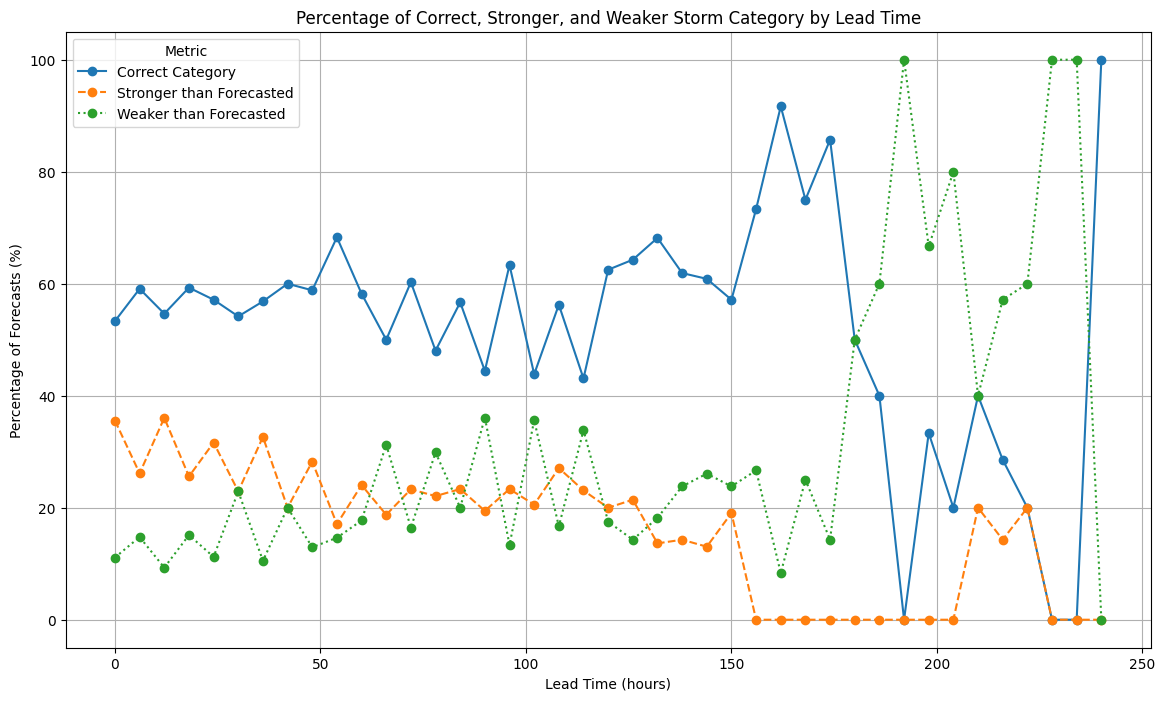

In [9]:
# Calculate total cases and percentages
combined_metrics = combined_metrics.groupby("lead_time").sum().reset_index()
combined_metrics["total_cases"] = (
    combined_metrics["correct_category"]
    + combined_metrics["stronger_than_forecasted"]
    + combined_metrics["weaker_than_forecasted"]
)

combined_metrics["percent_correct"] = (
    combined_metrics["correct_category"] / combined_metrics["total_cases"] * 100
)
combined_metrics["percent_stronger"] = (
    combined_metrics["stronger_than_forecasted"] / combined_metrics["total_cases"] * 100
)
combined_metrics["percent_weaker"] = (
    combined_metrics["weaker_than_forecasted"] / combined_metrics["total_cases"] * 100
)

# Plot the combined metrics
plt.figure(figsize=(14, 8))

# Plot correct category
plt.plot(
    combined_metrics["lead_time"],
    combined_metrics["percent_correct"],
    marker="o",
    label="Correct Category",
)

# Plot stronger than forecasted
plt.plot(
    combined_metrics["lead_time"],
    combined_metrics["percent_stronger"],
    marker="o",
    linestyle="--",
    label="Stronger than Forecasted",
)

# Plot weaker than forecasted
plt.plot(
    combined_metrics["lead_time"],
    combined_metrics["percent_weaker"],
    marker="o",
    linestyle=":",
    label="Weaker than Forecasted",
)

# Add plot details
plt.xlabel("Lead Time (hours)")
plt.ylabel("Percentage of Forecasts (%)")
plt.title("Percentage of Correct, Stronger, and Weaker Storm Category by Lead Time")
plt.legend(title="Metric")
plt.grid(True)
plt.show()

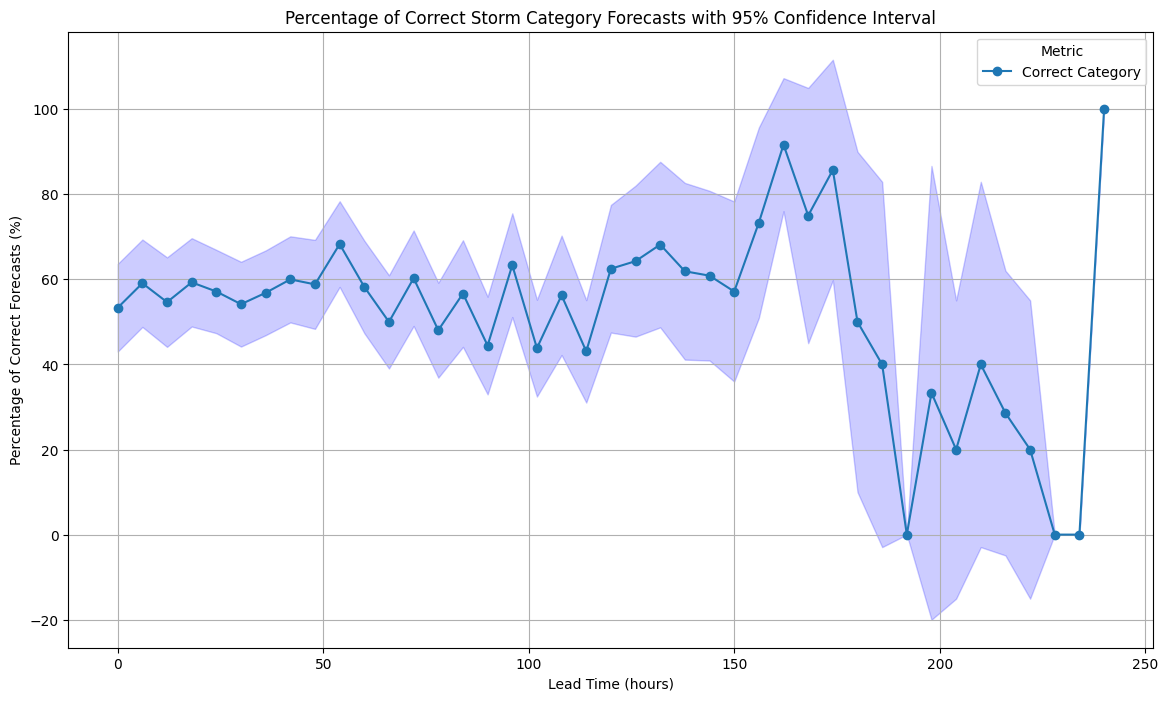

In [10]:
# Apply the confidence interval calculation
ci_results = combined_metrics.apply(
    lambda row: calculate_confidence_interval(
        row["correct_category"], row["total_cases"]
    ),
    axis=1,
)

# Unpack the results into separate columns
combined_metrics["ci_lower_correct"], combined_metrics["ci_upper_correct"] = zip(
    *ci_results
)

# Plot the 'Correct Category' with confidence intervals
plt.figure(figsize=(14, 8))

# Plot correct category
plt.plot(
    combined_metrics["lead_time"],
    combined_metrics["percent_correct"],
    marker="o",
    label="Correct Category",
)

# Plot confidence interval
plt.fill_between(
    combined_metrics["lead_time"],
    combined_metrics["ci_lower_correct"],
    combined_metrics["ci_upper_correct"],
    color="blue",
    alpha=0.2,
)

# Add plot details
plt.xlabel("Lead Time (hours)")
plt.ylabel("Percentage of Correct Forecasts (%)")
plt.title("Percentage of Correct Storm Category Forecasts with 95% Confidence Interval")
plt.legend(title="Metric")
plt.grid(True)
plt.show()

### Filtering for only those storms which are STS or TC

In [11]:
combined_metrics = calculate_metrics_by_category(
    gdf_points=gdf_points,
    save_dir=save_dir,
    categorize_cyclone=categorize_cyclone,
    category_order=category_order,
    storm_category_filters=[
        "Severe Tropical Storm",
        "Tropical Cyclone",
    ],  # List of categories to filter by
)

Processing file: G:\Shared drives\Predictive Analytics\CERF Anticipatory Action\General - All AA projects\Data\public\exploration\moz\ecmwf_hindcast\csv\favio_all.csv
Processing file: G:\Shared drives\Predictive Analytics\CERF Anticipatory Action\General - All AA projects\Data\public\exploration\moz\ecmwf_hindcast\csv\jokwe_all.csv
Processing file: G:\Shared drives\Predictive Analytics\CERF Anticipatory Action\General - All AA projects\Data\public\exploration\moz\ecmwf_hindcast\csv\izilda_all.csv
Processing file: G:\Shared drives\Predictive Analytics\CERF Anticipatory Action\General - All AA projects\Data\public\exploration\moz\ecmwf_hindcast\csv\dando_all.csv
Processing file: G:\Shared drives\Predictive Analytics\CERF Anticipatory Action\General - All AA projects\Data\public\exploration\moz\ecmwf_hindcast\csv\irina_all.csv
Processing file: G:\Shared drives\Predictive Analytics\CERF Anticipatory Action\General - All AA projects\Data\public\exploration\moz\ecmwf_hindcast\csv\haruna_all.

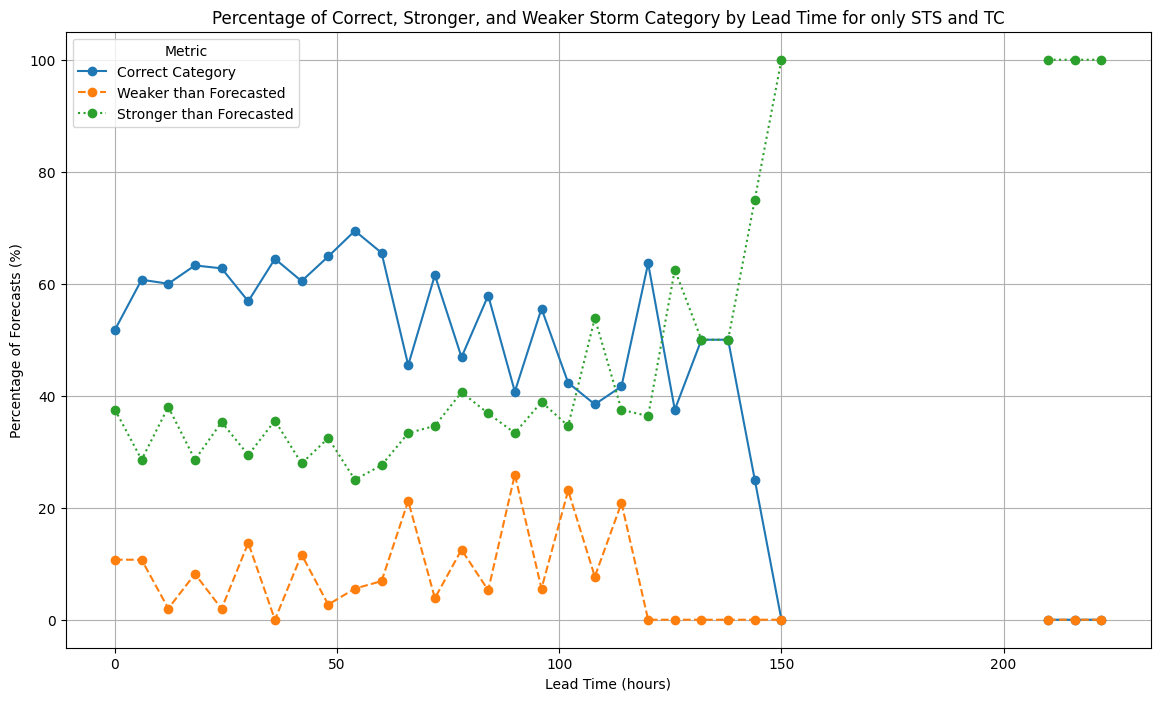

In [12]:
# Calculate total cases and percentages
combined_metrics = combined_metrics.groupby("lead_time").sum().reset_index()
combined_metrics["total_cases"] = (
    combined_metrics["correct_category"]
    + combined_metrics["stronger_than_forecasted"]
    + combined_metrics["weaker_than_forecasted"]
)

combined_metrics["percent_correct"] = (
    combined_metrics["correct_category"] / combined_metrics["total_cases"] * 100
)
combined_metrics["percent_stronger"] = (
    combined_metrics["stronger_than_forecasted"] / combined_metrics["total_cases"] * 100
)
combined_metrics["percent_weaker"] = (
    combined_metrics["weaker_than_forecasted"] / combined_metrics["total_cases"] * 100
)

# Plot the combined metrics
plt.figure(figsize=(14, 8))

# Plot hit rate (Correct Category)
plt.plot(
    combined_metrics["lead_time"],
    combined_metrics["percent_correct"],
    marker="o",
    label="Correct Category",
)

# Plot miss rate (Weaker than Forecasted)
plt.plot(
    combined_metrics["lead_time"],
    combined_metrics["percent_weaker"],
    marker="o",
    linestyle="--",
    label="Weaker than Forecasted",
)

# Plot false alarm rate (Stronger than Forecasted)
plt.plot(
    combined_metrics["lead_time"],
    combined_metrics["percent_stronger"],
    marker="o",
    linestyle=":",
    label="Stronger than Forecasted",
)

# Add plot details
plt.xlabel("Lead Time (hours)")
plt.ylabel("Percentage of Forecasts (%)")
plt.title(
    "Percentage of Correct, Stronger, and Weaker Storm Category by Lead Time for only STS and TC"
)
plt.legend(title="Metric")
plt.grid(True)
plt.show()

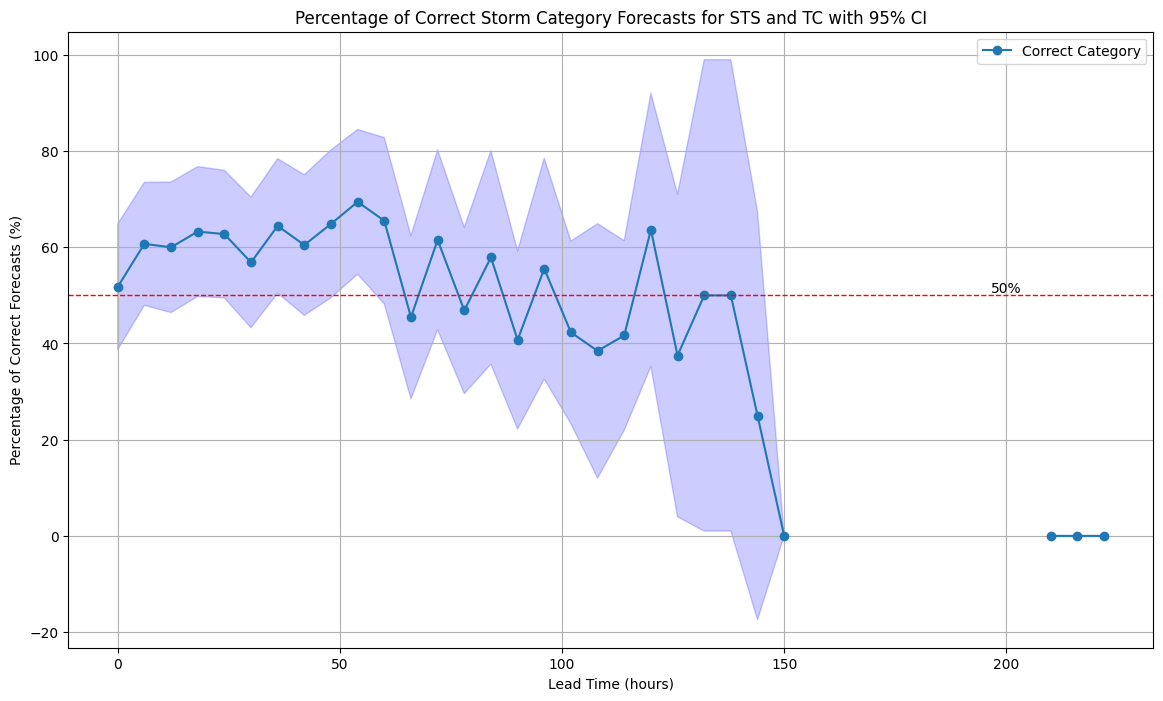

In [21]:
# Apply the confidence interval calculation
ci_results = combined_metrics.apply(
    lambda row: calculate_confidence_interval(
        row["correct_category"], row["total_cases"]
    ),
    axis=1,
)

# Unpack the results into separate columns
combined_metrics["ci_lower_correct"], combined_metrics["ci_upper_correct"] = zip(
    *ci_results
)

# Plot the 'Correct Category' with confidence intervals
plt.figure(figsize=(14, 8))

# Plot correct category
plt.plot(
    combined_metrics["lead_time"],
    combined_metrics["percent_correct"],
    marker="o",
    label="Correct Category",
)

# Plot confidence interval
plt.fill_between(
    combined_metrics["lead_time"],
    combined_metrics["ci_lower_correct"],
    combined_metrics["ci_upper_correct"],
    color="blue",
    alpha=0.2,
)

# Add plot details
plt.xlabel("Lead Time (hours)")
plt.ylabel("Percentage of Correct Forecasts (%)")
plt.title("Percentage of Correct Storm Category Forecasts for STS and TC with 95% CI")
plt.legend(title="")
plt.axhline(y=50, color="red", linestyle="--", linewidth=1)
plt.text(200, 50, "50%", color="black", ha="center", va="bottom")
plt.grid(True)
plt.show()